# Sailing domain: inference results 

In [1]:
import re
import numpy 
from scipy.stats import mode
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

ModuleNotFoundError: No module named 'numpy'

We collect and post-process result for a range of lake sizes and temperature values (the denominator in the exponent of the Bolzman/Gibbs distribution).

In [4]:
SIZES=[25, 50, 100]
LOGTEMPS=range(6)

The results are generated by running `sailing > samples.txt`. The output is a two-column CSV  "unit cost,travel cost". The summaries are printed to the standard error.

In [5]:
# We want to keep notebooks self-contained, so just put the ess estimator inline.
import scipy.fft

def ess(samples):
    """effective sample size"""    
    coeff = scipy.fft.fft(samples-samples.mean(), 2**int(numpy.floor(numpy.log2(len(samples)))))
    rhos = scipy.fft.ifft(coeff*numpy.conj(coeff))
    
    # compute effective sample size, stop when
    # the sum of two consecutive cross-correlations
    # becomes negative
    sum = 0.
    for i in range(1, len(samples)-1, 2):
        p = rhos[i] + rhos[i+1]
        if p < 0:
            break
        sum += p
    # cross-corellations are not normalized
    # and must be divided by cross-corellation at 0
    sum = numpy.real(sum/rhos[0])

    return len(samples) / (1. + sum)

In [16]:
costs = {}
modes = []
print("size\tlogtemp\tess\n"+("-"*20))
for size in SIZES:
    costs[size] = {}
    for logtemp in LOGTEMPS:
        d = numpy.genfromtxt(f"results/samples-{size}-{logtemp}.csv", delimiter=",")
        costs[size][logtemp] = d
        print(f"{size}\t{logtemp}\t{ess(d[:, 0]):.0f}")
        if logtemp == numpy.max(LOGTEMPS):
            modes.append(mode(numpy.round(costs[size][logtemp][:, 0], decimals=1)).mode[0])

size	logtemp	ess
--------------------
25	0	2609
25	1	2753
25	2	2906
25	3	2501
25	4	2621
25	5	2481
50	0	2529
50	1	2760
50	2	2874
50	3	2473
50	4	2520
50	5	3585
100	0	2141
100	1	2345
100	2	2291
100	3	3061
100	4	5957
100	5	8516


In [11]:
summaries = {}
for size in SIZES:
    summaries[size] = {}
    for logtemp in LOGTEMPS:
        with open(f"results/summary-{size}-{logtemp}.txt") as f:
            record = {}
            for line in f:
                tokens = re.match("(.*): (.*)", line)
                label = tokens.group(1).strip()
                value = float(tokens.group(2))
                if label=="Mean travel cost":
                    record["inferred"] = value
                elif label=="Mean optimistic travel cost":
                    record["optimistic"] = value
                elif label=="Mean optimal travel cost":
                    record["optimal"] = value
                elif label=="Mean greedy travel cost":
                    record["greedy"] = value
                summaries[size][logtemp] = record

We show histograms for both the unit cost and the travel cost, and report the mode (the best value) for the unit cost and the mean for the travel cost (taken over the distribution of unit costs). The sharpness of the unit cost distribution depends on the temperature. The lower is the temperature, the more contentrated the distributed around its mode.

unit cost


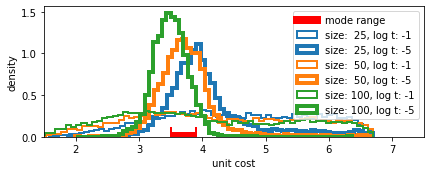

travel cost


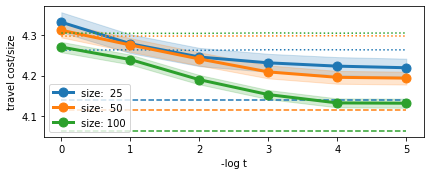

In [17]:
cmap = cm.get_cmap('tab10')
figscale=0.8
figsize=(8.5*figscale, 3.0*figscale)
#figsize=(5.5*figscale, 3.5*figscale)
sfx="-wide"
print("unit cost")
plt.figure(figsize=figsize)
plt.xlim(1.5, 7.5)
for i, size in enumerate(SIZES):
    for j in range(1, len(LOGTEMPS), 4):
        logtemp = LOGTEMPS[j]
        c = costs[size][logtemp]
        plt.hist(c[:,0], bins=64, histtype="step",  lw=1.5+0.5*j, color=cmap.colors[i],
                 label=f"size: {size:>3d}, log t: -{logtemp}", density=True)
plt.plot([min(modes)+0.05, max(modes)-0.05], [0.01, 0.01],  lw=8, color="red", label="mode range")
plt.plot([min(modes), min(modes)], [0, 0.1], lw=2, color="red")
plt.plot([max(modes), max(modes)], [0, 0.1], lw=2, color="red")

plt.ylabel("density")
plt.xlabel("unit cost")
plt.legend()
plt.savefig(f"unit-costs{sfx}.svg")
plt.savefig(f"unit-costs{sfx}.pdf")
plt.show()

print("travel cost")
plt.figure(figsize=figsize)
for i, size in enumerate(SIZES):
    inferred = []
    infstd = []
    optimistic = []
    optimal = []
    greedy = []
    for logtemp in LOGTEMPS:
        inferred.append(summaries[size][logtemp]["inferred"]/size)
        infstd.append(numpy.std(costs[size][logtemp][:, 1])/numpy.sqrt(len(costs[size][logtemp][:, 0]))/size)
        optimistic.append(summaries[size][logtemp]["optimistic"]/size)
        optimal.append(summaries[size][logtemp]["optimal"]/size)
        greedy.append(summaries[size][logtemp]["greedy"]/size)
    inferred = numpy.array(inferred)
    infstd  = numpy.array(infstd)
    plt.plot(LOGTEMPS, inferred, markersize=9, marker='o', lw=3, c=cmap.colors[i], label=f"size: {size:>3d}")
    plt.fill_between(LOGTEMPS, inferred-1.96*infstd, inferred+1.96*infstd, color=cmap.colors[i], alpha=0.2)
    plt.plot(LOGTEMPS, optimal, ls='dashed', c=cmap.colors[i])
    plt.plot(LOGTEMPS, greedy, ls='dotted', c=cmap.colors[i])
plt.ylabel("travel cost/size")
plt.xlabel("-log t")
plt.legend(loc="lower left")
plt.savefig(f"travel-costs{sfx}.svg")
plt.savefig(f"travel-costs{sfx}.pdf")
plt.show()        
_=_